In [1]:
% matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import json
import matplotlib.gridspec as gridspec
import copy
import seaborn as sns
from scipy.stats import ttest_1samp
import sys
sys.path.append('..')
from helpers.glove_neighbors import *
from helpers.funcs import *

In [2]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
cluster_names = {v:k for k, v in config['CLUSTER_NAMES'].items()}

In [3]:
cluster_method = '_relative'
#cluster_method = ''

In [4]:
means = np.load(OUTPUT_DIR + 'cluster_' + str(NUM_CLUSTERS) +'_means.npy')
glove = pd.read_csv(OUTPUT_DIR+'glove.50d.csv', sep='\t', index_col=0)

In [5]:
for m in means:
    print(neighbors_vector(m, glove).head(5))
    print('-----')

extremist    0.430352
radic        0.447986
racist       0.471680
ideolog      0.481337
label        0.485222
dtype: float64
-----
#break          0.311975
custodi         0.342106
#breakingnew    0.364076
#updat          0.367732
confirm         0.375000
dtype: float64
-----
bar           0.279283
thousand      0.364697
california    0.415307
calif         0.433880
among         0.500639
dtype: float64
-----
sensibl    0.479689
regul      0.490230
requir     0.525997
access     0.534226
abid       0.538834
dtype: float64
-----
suspect      0.354829
arrest       0.431363
alleg        0.453734
apprehend    0.472367
custodi      0.479943
dtype: float64
-----
affect         0.363040
senseless      0.377327
ach            0.396949
heart          0.423212
heartbroken    0.424932
dtype: float64
-----
honor          0.299040
memori         0.346227
tuesday        0.356018
candlelight    0.391838
flown          0.398403
dtype: float64
-----
dude     0.525011
yeah     0.545372
eat      0.562512

In [6]:
cluster_words = {}
for i, m in enumerate(means):
    cluster_words[i] = ', '.join(neighbors_vector(m, glove).head(10).index)

In [7]:
cluster_words

{0: 'extremist, radic, racist, ideolog, label, rhetor, wing, blm, islamist, christian',
 1: '#break, custodi, #breakingnew, #updat, confirm, fatal, multipl, updat, unconfirm, sever',
 2: 'bar, thousand, california, calif, among, los, southern, veteran, angel, via',
 3: 'sensibl, regul, requir, access, abid, #gunreformnow, legisl, argument, allow, #guncontolnow',
 4: 'suspect, arrest, alleg, apprehend, custodi, charg, accus, prosecutor, #break, ap',
 5: 'affect, senseless, ach, heart, heartbroken, sadden, faculti, pray, #prayer, deepest',
 6: 'honor, memori, tuesday, candlelight, flown, vigil, gather, observ, honour, capitol',
 7: 'dude, yeah, eat, huh, gonna, ain, shit, ass, damn, guess'}

# topic proportions

In [8]:
cluster_proportions = {i:[] for i in range(NUM_CLUSTERS)}
for event in events:
    data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',
                       usecols=['user_id'])
    data = get_cluster_assignments(event, data, cluster_method)
    labels = data['topic']
    props = np.bincount(labels) / np.sum(np.bincount(labels))
    for i, j in enumerate(props):
        cluster_proportions[i].append(j)

In [9]:
for k, v in cluster_proportions.items():
    print(cluster_names[k], np.mean(v))

shooter's identity
& ideology 0.11116573033642113
news 0.19334260320341667
victims & location 0.043614349023642154
laws & policy 0.1378732614356925
investigation 0.0911579226567265
solidarity 0.1318272759458564
remembrance 0.058627288506242776
other 0.2323915688920019


# topic log odds

In [86]:
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))

In [11]:
event_list = []
log_odds_list = []
topic_list = []
race = []
for event in events:
    print(event)
    event_list.extend([event] * NUM_CLUSTERS)
    data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',usecols=['dem_follows', 'rep_follows'])
    data = get_cluster_assignments(event, data, cluster_method[1:])
    dem, rep = split_party(data)
    dem_total = len(dem)
    rep_total = len(rep)
    
    for i in range(NUM_CLUSTERS):
        dem_cluster = (dem['topic']==i).sum()
        rep_cluster = (rep['topic']==i).sum()
        odds =  np.log((rep_cluster / (rep_total - rep_cluster)) / (dem_cluster / (dem_total - dem_cluster)))
        topic_list.append(cluster_names[i])
        log_odds_list.append(odds)
        race.append(shooter_race[event])
        print(cluster_names[i], 'odds', odds)
        
    print()
    print('------')
    

chattanooga
shooter's identity
& ideology odds -0.0066638928522766774
news odds -0.18311120033007994
victims & location odds -0.353917230059806
laws & policy odds 0.1954503686184051
investigation odds 0.04579629021958547
solidarity odds -0.25906156663050667
remembrance odds 0.5106217346245219
other odds 0.0016699661113487162

------
roseburg
shooter's identity
& ideology odds 0.9047129615544178
news odds 0.09772117640777661
victims & location odds -0.05151895654314489
laws & policy odds -0.025324408928047038
investigation odds 0.45398006084950154
solidarity odds -0.28636655012221707
remembrance odds -0.0596720614617409
other odds 0.002669663371521585

------
colorado_springs
shooter's identity
& ideology odds -0.4347948857663359
news odds 0.8852571249235567
victims & location odds 0.020403937557828686
laws & policy odds -0.21520196637647648
investigation odds 0.4232841615290662
solidarity odds 0.007835234544412413
remembrance odds -0.10526723819368933
other odds -0.13292837790296716

-

In [12]:
df = pd.DataFrame.from_dict({'event':event_list, 'topic':topic_list, 'log_odds':log_odds_list, 'race':race})

In [10]:
for i, g in df.groupby('topic'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

investigation
Ttest_1sampResult(statistic=5.058122059957572, pvalue=6.0143425820420953e-05)
laws & policy
Ttest_1sampResult(statistic=-2.0346594124403468, pvalue=0.05535912587378851)
news
Ttest_1sampResult(statistic=2.7772451130539606, pvalue=0.01162702896887936)
other
Ttest_1sampResult(statistic=-6.1068287694796775, pvalue=5.73370008689666e-06)
remembrance
Ttest_1sampResult(statistic=-0.906155968506492, pvalue=0.37564140162708737)
shooter's identity
& ideology
Ttest_1sampResult(statistic=2.54550725724709, pvalue=0.019261681309326005)
solidarity
Ttest_1sampResult(statistic=-5.096210613356596, pvalue=5.51152728232597e-05)
victims & location
Ttest_1sampResult(statistic=1.0468249111389736, pvalue=0.30766753705427785)


[None, None]

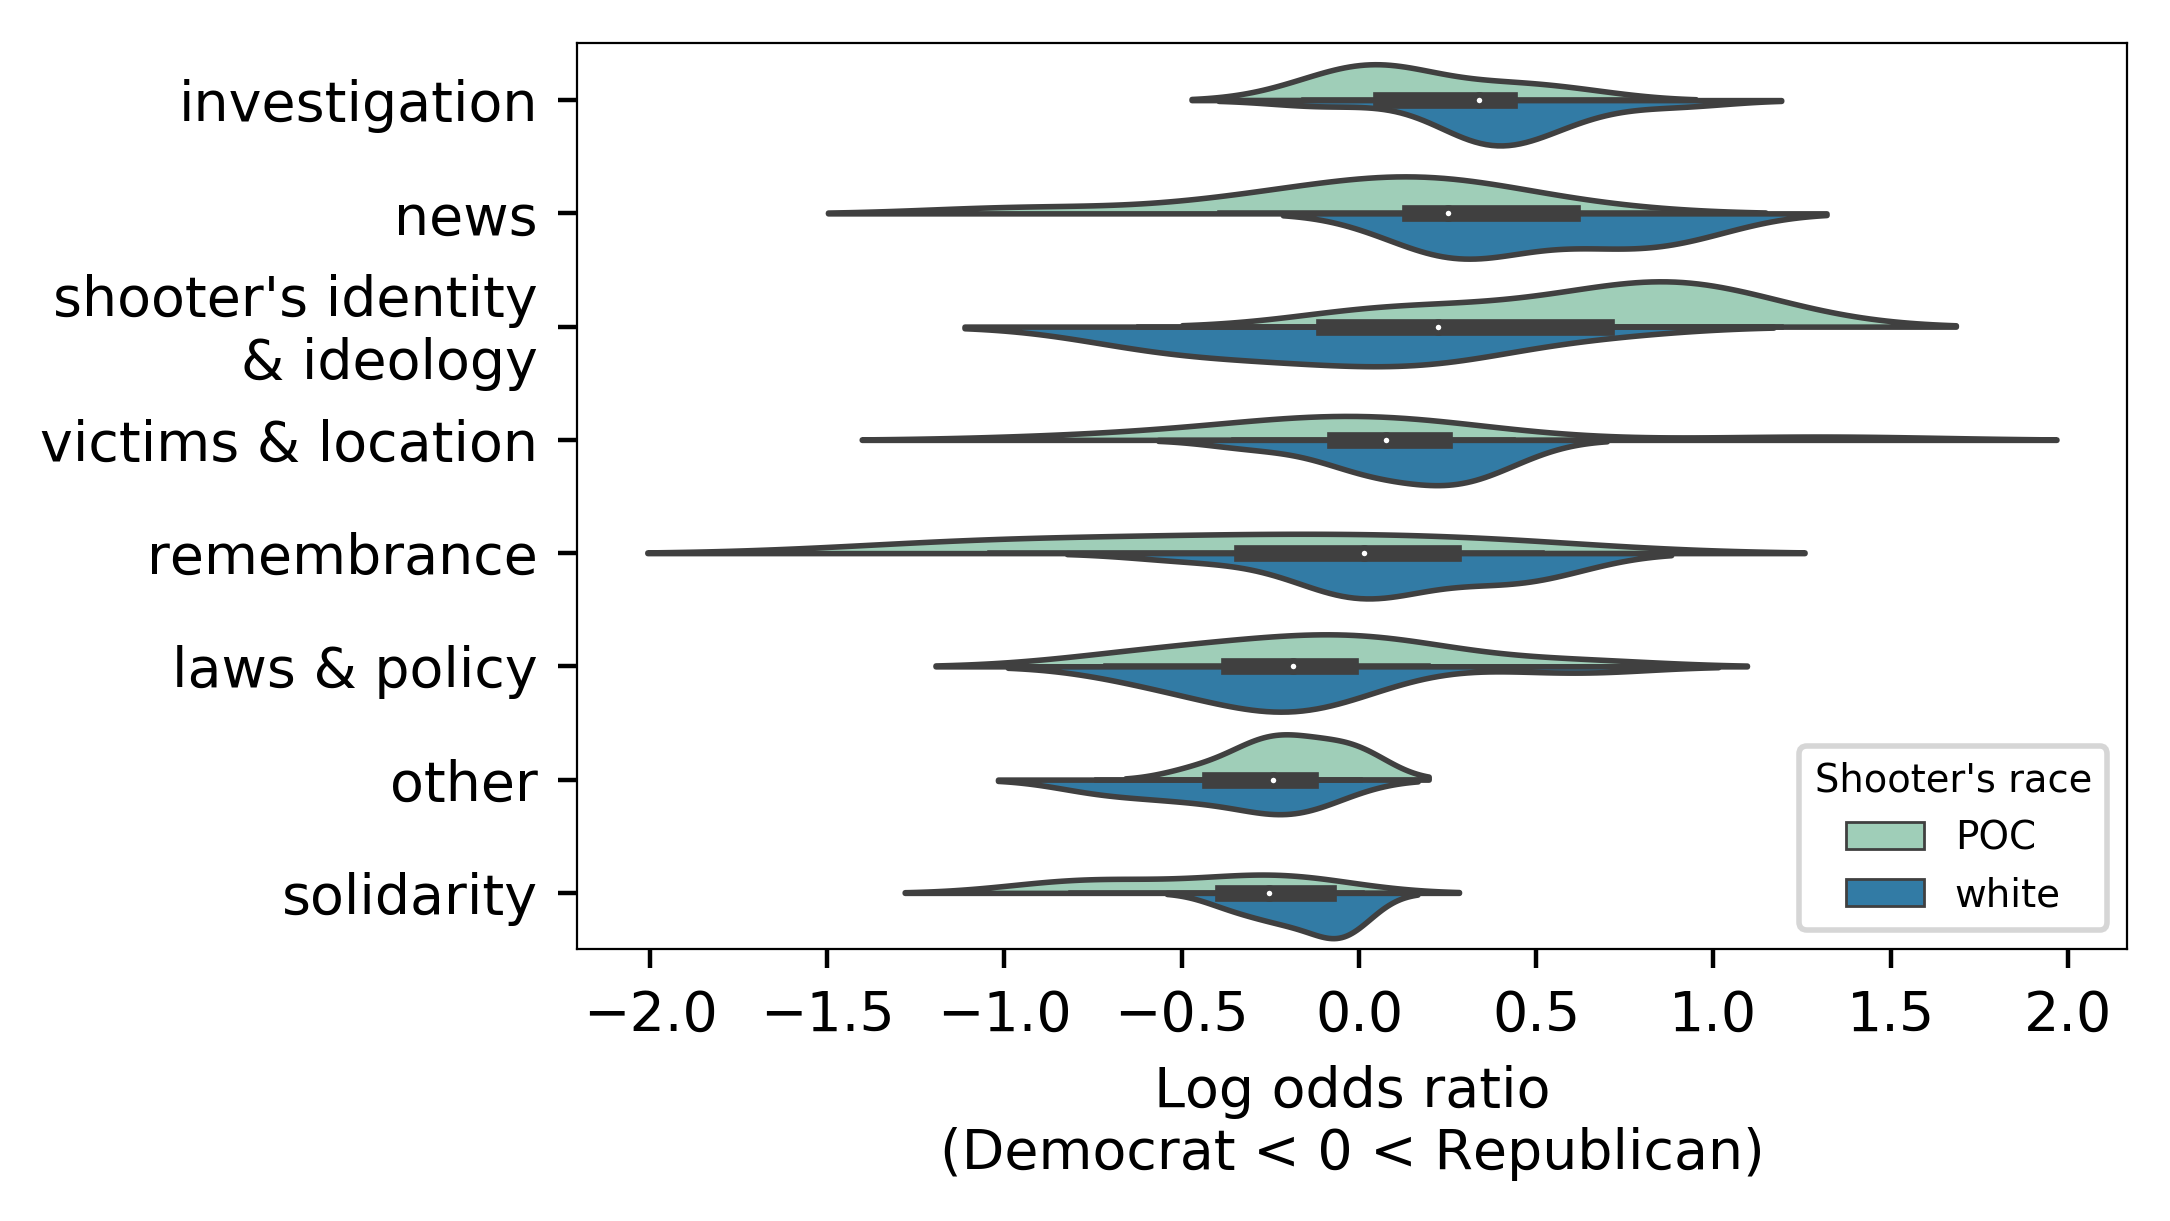

In [15]:
f = plt.figure(dpi=400, edgecolor='grey', figsize=(5,3))
ax = sns.violinplot(data=df, x="log_odds",y="topic", hue='race', split=True, linewidth=1, order=reversed(df.groupby('topic').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
#plt.axvline(x=0, color='grey')
legend = plt.legend(title="Shooter's race", fontsize=7, loc='lower right')
plt.setp(legend.get_title(),fontsize='x-small')

[None, None]

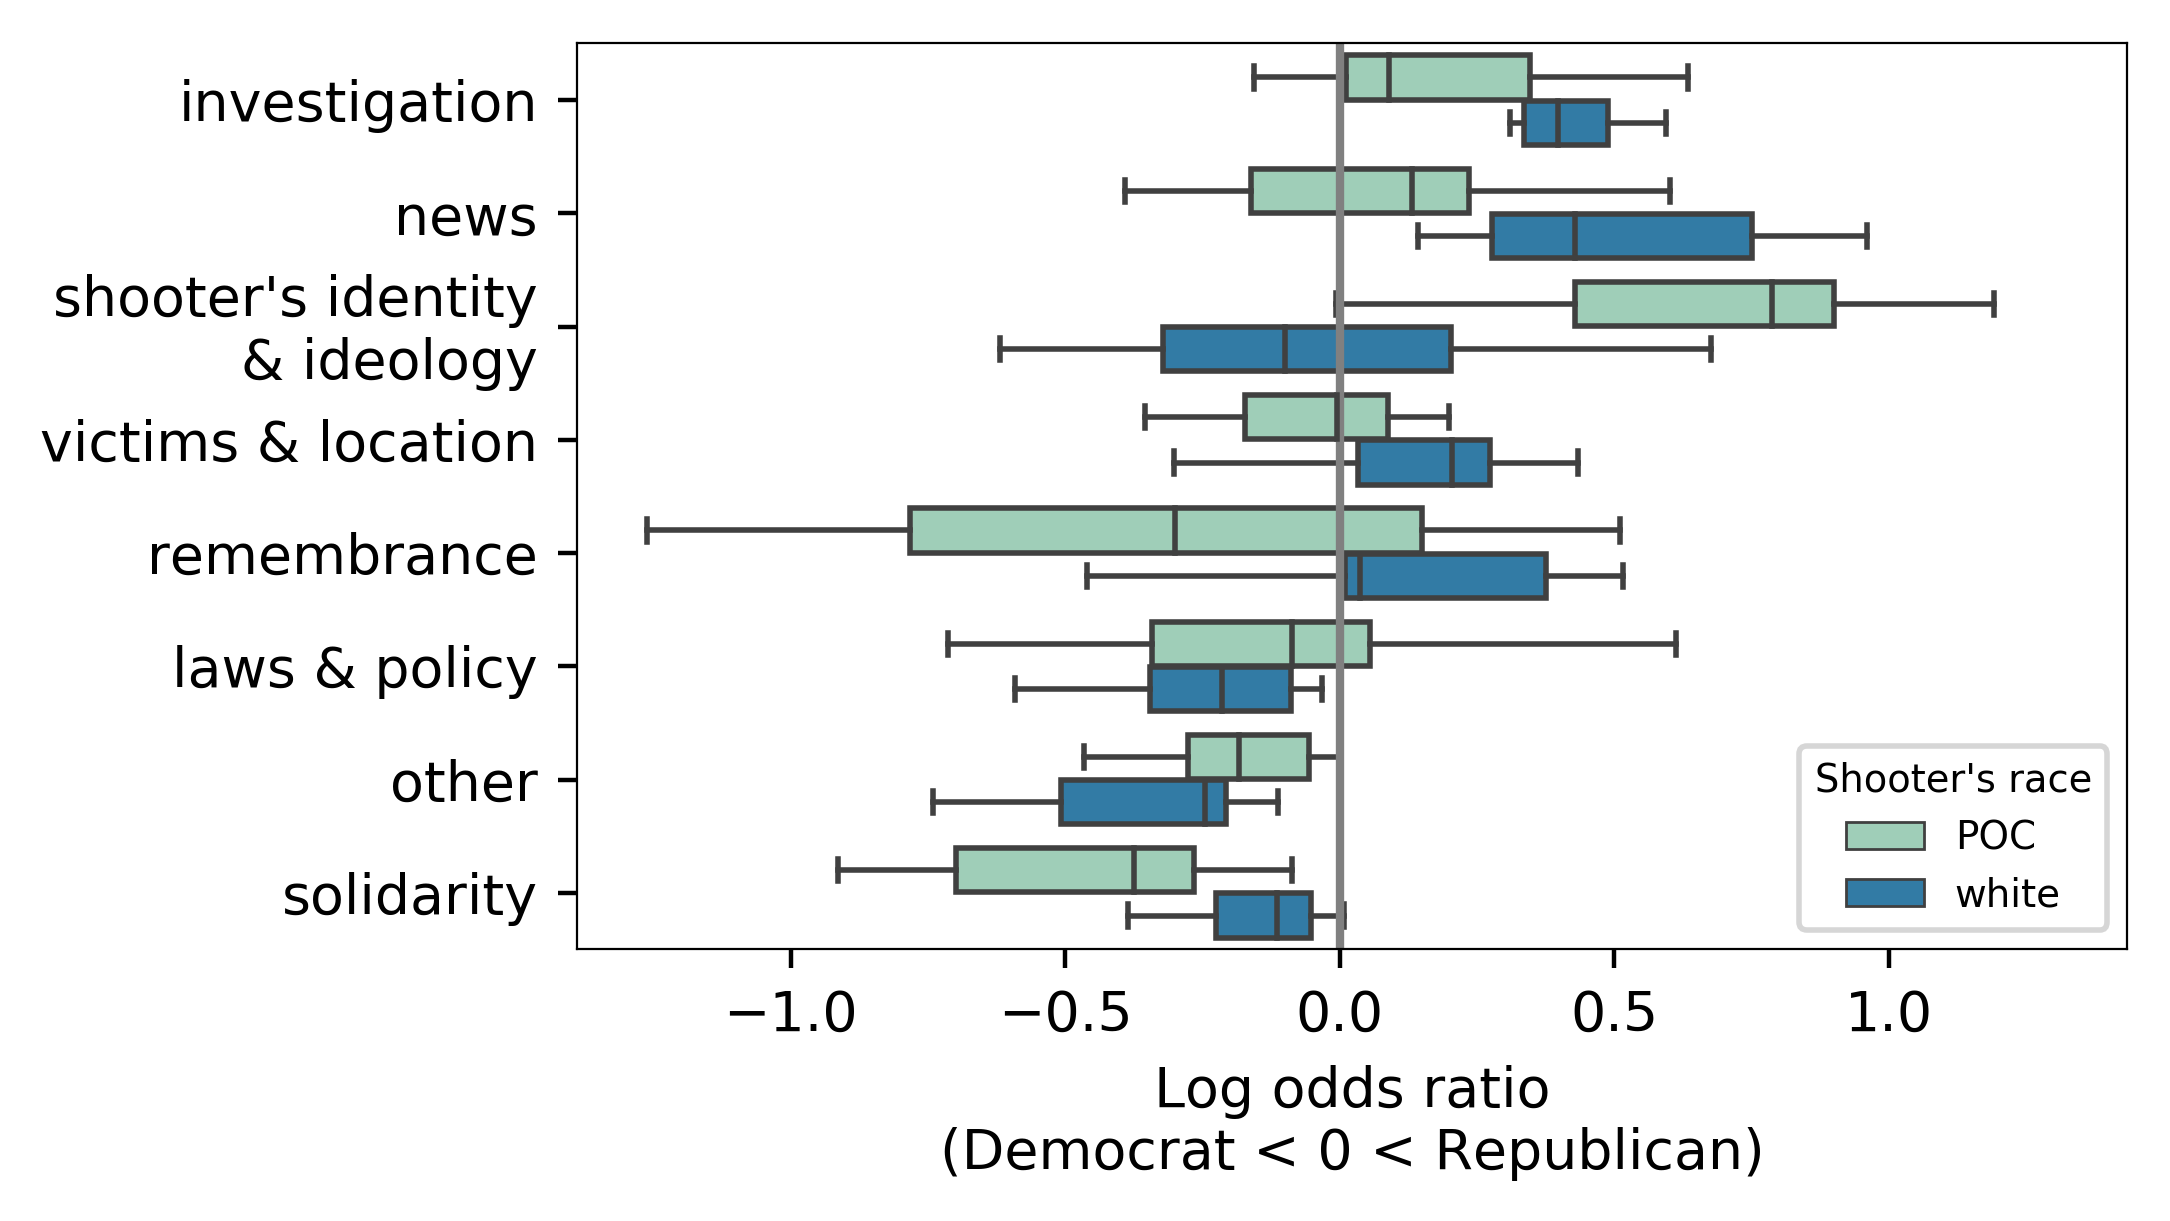

In [14]:
f = plt.figure(dpi=400, edgecolor='grey', figsize=(5,3))
ax = sns.boxplot(data=df, x="log_odds",y="topic", hue='race', linewidth=1,fliersize=0, order=reversed(df.groupby('topic').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
plt.axvline(x=0, color='grey')
legend = plt.legend(title="Shooter's race", fontsize=7, loc='lower right')
plt.setp(legend.get_title(),fontsize='x-small')

# plot topic polarization over time

In [6]:
hour = 60 * 60
day = 24 * hour
split_by = 24 * hour
no_splits = int((day / split_by) * 14)  # 14 days

In [7]:
def get_buckets(data, timestamp):
    '''Divide tweets into time buckets.'''
    timestamps = data['timestamp'].astype(float)
    buckets = []
    start = timestamp
    for i in range(no_splits):
        new_start = start + split_by
        b = data[(timestamps > start) & (timestamps < new_start)]
        start = new_start
        buckets.append(b)
    return buckets

In [19]:
def plot_clusters(events):
    '''Plot polarization over time (average value for all the events in params). We only use ["vegas"] in the paper.'''
    num_splits = 9 # 9 days
    T = (np.arange(num_splits) + 1)
    freqs = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # topic frequencies
    actual = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # actual leaveout value
    random = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # random leaveout value
    for k, e in enumerate(events):
        pol = json.load(open(TWEET_DIR + e + '/' + e + '_topic_polarization_over_time'+cluster_method+'.json', 'r'))
        for i in range(num_splits):
            for j in range(NUM_CLUSTERS):
                freqs[i, j, k] = int(pol[str(i)][str(j)][2])
                actual[i, j, k] = float(pol[str(i)][str(j)][0])
                random[i, j, k] = float(pol[str(i)][str(j)][1])
            freqs[i, :, k] = freqs[i, :, k] / np.sum(freqs[i, :, k])  # turn frequencies into topic proportions
        
    mean_freqs = np.mean(freqs, axis=2)
    mean_actual = np.mean(actual, axis=2)
    mean_random = np.mean(random, axis=2)
    
    ro = {0:1, 1:4, 2:2, 3:0, 4:5, 5:6, 6:3, 7:7}   # order of plots (i.e. topics), order in plot (key): topic_no (value)
    
    row_num = 2
    col_num = 4
    sns.reset_orig()  # get default matplotlib styles back
    clrs = sns.color_palette('husl', n_colors=NUM_CLUSTERS)  # a list of RGB tuples
    
    #fig, ax = plt.subplots(row_num, col_num, dpi=400, sharex='col', sharey='row')
    fig = plt.figure(dpi=600,figsize=(6.7,3))
    outer = gridspec.GridSpec(row_num, col_num, hspace=0.22, wspace=0.08)
    #fig.subplots_adjust(hspace=0.6, wspace=0.1)

    #fig.suptitle('Temporal polarization of topics', y=.93, fontsize=9)
    # axes are in a two-dimensional array, indexed by [row, col]
    for c in range(row_num * col_num):
        cluster = ro[c]
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[c], wspace=0, hspace=.1, height_ratios=[3,1])
        
        for j in range(2):   # the two subplots (polarization and frequency)
            ax = plt.Subplot(fig, inner[j])
            if j == 0:
                ax.set_title(cluster_names[cluster], fontsize=10, y=.95)
                lines = ax.plot(T, mean_actual[:, cluster])  # actual
                lines[0].set_color(clrs[c])
                #lines = ax.plot(T, mean_random[:, cluster], '--')  # random
                #lines[0].set_color(clrs[c])
                ax.tick_params('y', labelsize=8)
                ax.set_xticks([])
                if c not in [0,4]:
                    ax.tick_params('y', labelsize=8, labelleft=False)
                else:
                    ax.tick_params('y', labelsize=8)
                    ax.set_ylabel('Polarization', fontsize=9)
                ax.yaxis.grid(color='gray', alpha=0.3, linewidth=.5)
                ax.set_ylim(.47, .61)   # set the ylims of the polarization plots
            else:
                ax.bar(T, mean_freqs[:, cluster], color='lightgray', width=.87, edgecolor='darkgrey')
                ax.set_ylim(0, .46)
                #ax.set_yticks([])
                if c not in [0,4]:
                    ax.tick_params('y', labelsize=8, labelleft=False)
                else:
                    ax.tick_params('y', labelsize=8)
                if c not in [4,5,6,7]:
                    ax.set_xticks([])
                else:
                    ax.set_xticks(np.array([1,3,5,7, 9])+.25)
                    ax.set_xticklabels([int(t) for t in np.array([1,3,5,7, 9])+.25])
                    ax.tick_params('x', labelsize=9)
                if c == 5:
                    ax.set_xlabel('Day after event', fontsize=10, x=1)
                if c in [0, 4]:
                    ax.set_ylabel('Freq.', fontsize=8)
                    
                
            ax.spines['bottom'].set_linewidth(0.5)
            ax.spines['left'].set_linewidth(0.5)
            ax.spines['top'].set_linewidth(0.5)
            ax.spines['right'].set_linewidth(0.5)
            fig.add_subplot(ax)
    #outer.tight_layout(fig)
    plt.show()

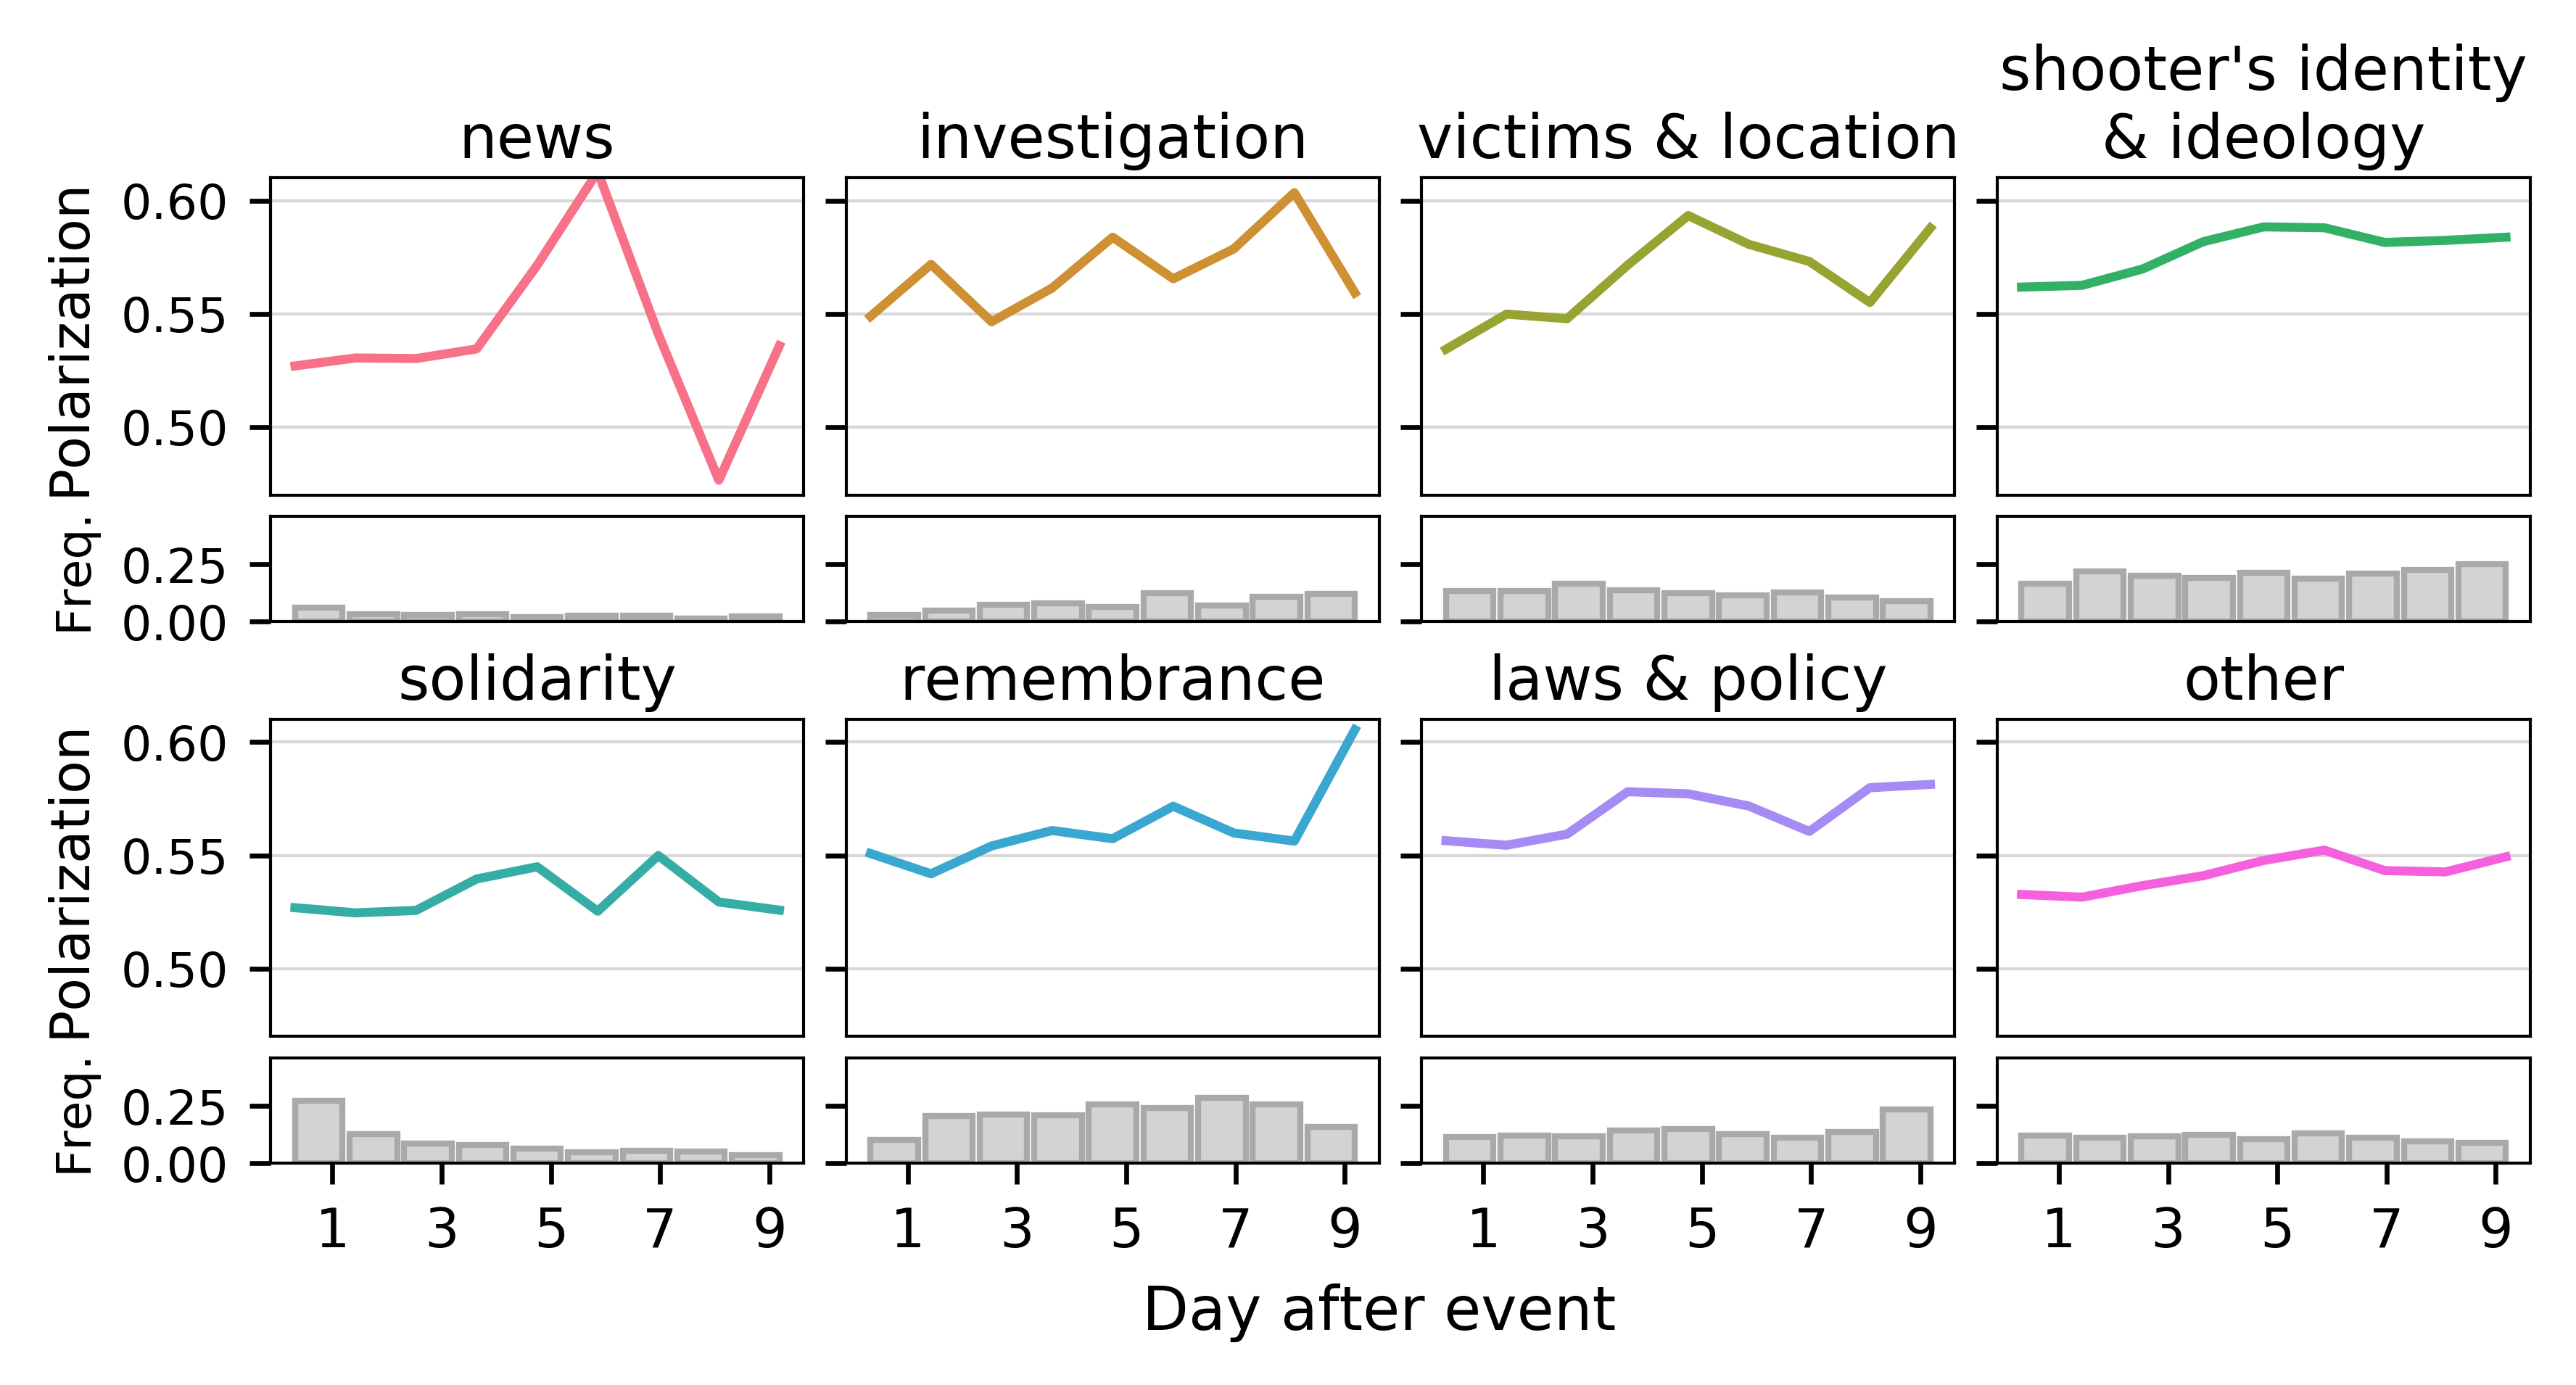

In [20]:
plot_clusters(['orlando'])  # the values from events in the list wil

# within topic polarization values across events

In [71]:
vals = {i: [] for i in range(NUM_CLUSTERS)}
ex = ['fort_lauderdale']
for e in events:
    if e in ex:
        continue
     
    within_topic_pol = json.load(open(TWEET_DIR +e+"/"+e+"_topic_polarization"+cluster_method+".json","r"))
    
    # get the topic proportions
    topics = pd.read_csv(TWEET_DIR + e + '/' + e + '_kmeans_topics_' + str(NUM_CLUSTERS) + '.csv')
    if cluster_method != '':
        _, topics = get_assigned_indices_relative(topics) if cluster_method == '_relative' else get_assigned_indices_absolute(topics)
        
    print(e, len(topics))
    for i in range(NUM_CLUSTERS):
        vals[i].append(float(within_topic_pol[str(i)][0]))

chattanooga 16344
roseburg 9476
colorado_springs 31199
san_bernardino 34557
kalamazoo 5391
orlando 645073
dallas 112276
baton_rouge 22566
burlington 3931
fresno 4852
san_francisco 5164
vegas 532763
thornton 7149
sutherland_springs 79361
parkland 139777
nashville 19363
santa_fe 33390
annapolis 14458
pittsburgh 28493
thousand_oaks 52530


In [74]:
for k, v in vals.items():
    print(cluster_names[k], np.mean(v))

shooter's identity
& ideology 0.5467233736605427
news 0.5140348019208755
victims & location 0.5159784402904355
laws & policy 0.5440638447533199
investigation 0.5266947931105772
solidarity 0.5207210731232703
remembrance 0.5229674700609288
other 0.523977825409129


# explore the news topic

In [95]:
dem_data = {}
rep_data = {}
event_weights = {}
for event in events:
    try:
        data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',
                       usecols=['user_screen_name', 'text', 'id', 'dem_follows', 'rep_follows', 'followers_count'])
        data = get_cluster_assignments(event, data, cluster_method)
        dem, rep = split_party(data)
        dem_data[event] = dem
        rep_data[event] = rep
        event_weights[event] = len(dem) + len(rep)
    except:
        continue

In [99]:
sum_weights = sum(event_weights.values())
for k, v in event_weights.items():
    event_weights[k] = v / sum_weights

In [96]:
def filter_data(data):
    data = data[~data['user_screen_name'].str.contains(r'fox|news', case=False) & ~data['text'].str.contains(r'fox', case=False)]
    return data

In [97]:
def get_topics(data):
    data = data[(data['topic'] == 1) | (data['topic'] == 4)]
    return data

In [122]:
dem_all = []
rep_all = []
dem_news = []
rep_news = []
race = []
event_name = []
n = 10000
for e, dem in dem_data.items():
    print(e)
    rep = rep_data[e]
    dem_t = get_topics(dem)
    rep_t = get_topics(rep)
    dem_all.append((dem['followers_count'] >= n).sum() / len(dem) )
    rep_all.append((rep['followers_count'] >= n).sum() / len(rep))
    rep_news.append((rep_t['followers_count'] >= n).sum() / len(rep_t))
    dem_news.append((dem_t['followers_count'] >= n).sum() / len(dem_t))
    race.append(shooter_race[e])
    event_name.append(e)
    #print((dem['followers_count'] >= 10000).sum() / len(dem), (rep['followers_count'] >= 10000).sum() /len(rep))
    #print((dem_t['followers_count'] >= 10000).sum() / len(dem_t), (rep_t['followers_count'] >= 10000).sum() /len(rep_t))
    #print('dem', (dem_t['followers_count'] >= 10000).sum())
    #print('rep', (rep_t['followers_count'] >= 10000).sum())
    
    
    #print('----')
    
    #print(t['isrep'].sum() / total)
    #print(t['user_screen_name'].str.contains('fox', case=False).sum() / total)
    
    #print(t.sample(10))
df = pd.DataFrame({'dem_all': dem_all, 'rep_all': rep_all, 'dem_news': dem_news, 'rep_news': rep_news, 'event': event_name, 'race': race})

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


In [123]:
long = pd.melt(df,id_vars=['event', 'race'],var_name='type', value_name='proportion')

In [124]:
long['party'] = long['type'].str.contains('dem')

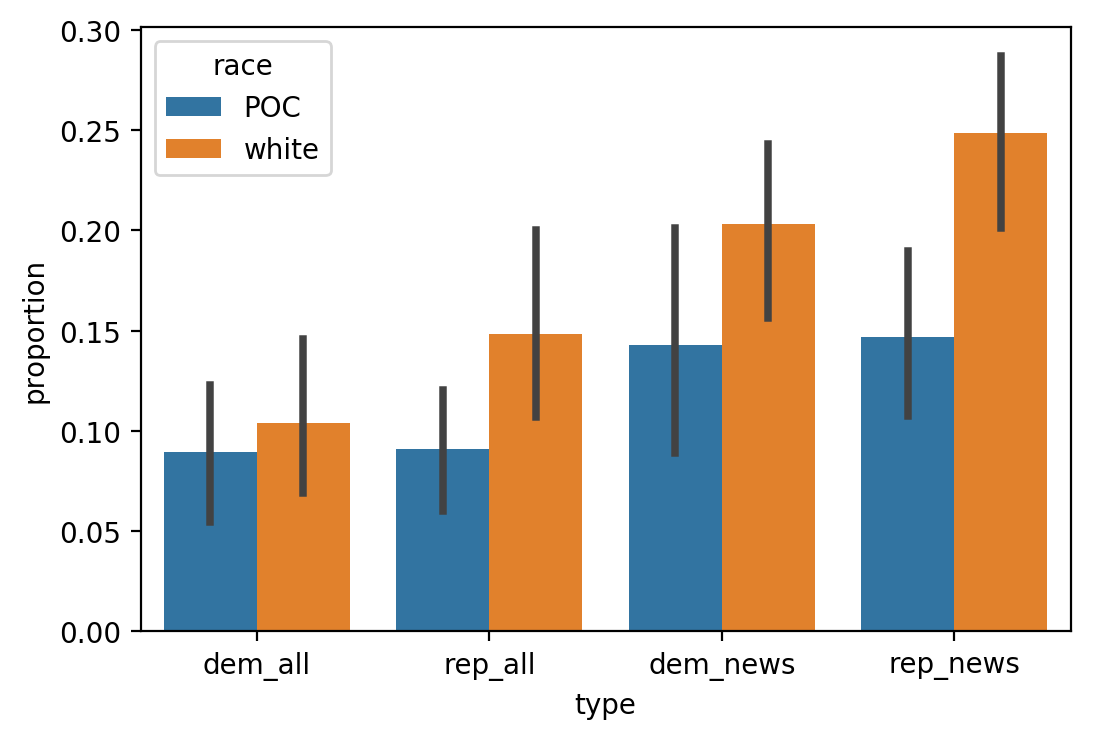

In [128]:
f = plt.figure(dpi=200)
sns.barplot(x='type', y='proportion', hue='race',  data=long)

In [68]:
vals = []
weights = []
for e, dem in dem_data.items():
    print(e)
    rep = rep_data[e]
    dem = filter_data(dem)
    rep = filter_data(rep)
    dem_t = get_topics(dem)
    rep_t = get_topics(rep)
    dem_odds = len(dem_t) / (len(dem) - len(dem_t))
    rep_odds = len(rep_t) / (len(rep) - len(rep_t))
    print(rep_odds / dem_odds)
    vals.append(rep_odds / dem_odds)
    weights.append(len(rep) + len(dem))
    
    #print(t['isrep'].sum() / total)
    #print(t['user_screen_name'].str.contains('fox', case=False).sum() / total)
    
    #print(t.sample(10))

chattanooga
0.8357237361252157
roseburg
1.0953262436450446
colorado_springs
2.1070971178311058
san_bernardino
0.9849560668153187
kalamazoo
2.0299491520481605
orlando
1.6328382312152199
dallas
1.0716354127008292
baton_rouge
1.2297641540915847
burlington
0.9737372357501451
fort_lauderdale
1.1980665038191267
fresno
0.6570560398505603
san_francisco
1.6536122340296773
vegas
1.578155482183551
thornton
2.5606427300555867
sutherland_springs
1.361371723169693
parkland
2.0256984527460817
nashville
1.6567899522036096
santa_fe
1.4979326991640574
annapolis
1.3720158845608013
pittsburgh
1.058096769651472
thousand_oaks
1.1316141161850841


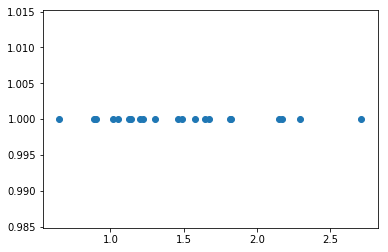

In [66]:
plt.scatter(vals, len(vals) * [1])

In [67]:
np.average(vals, weights=weights)

1.5905166627640448

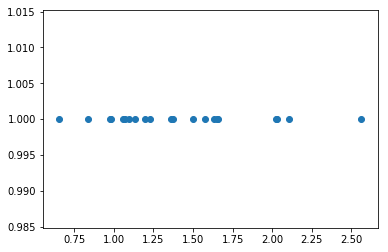

In [69]:
plt.scatter(vals, len(vals) * [1])

In [70]:
np.average(vals, weights=weights)

1.544394160494816

In [62]:
1.59 / 1.54

1.0324675324675325